In [1]:
%load_ext autoreload
%autoreload 2
import scanpy as sc
import scvi
import numpy as np
import pandas as pd
import scanpy_helpers.de as de
from scanpy_helpers.annotation import AnnotationHelper
from warnings import filterwarnings
from pygenesig.gini import GiniSignatureGenerator
import itertools
import matplotlib.pyplot as plt

sc.settings.verbosity = 2

filterwarnings("ignore", category=FutureWarning)
sc.set_figure_params(figsize=(5, 5))
import re

In [2]:
output_dir = "../../data/50_myeloid_cells/30_de_analysis"

In [3]:
adata = sc.read_h5ad(
    "../../data/50_myeloid_cells/20_cell_type_annotation/adata_annotated.h5ad"
)
adata_scvi = sc.read_h5ad(
    "../../data/50_myeloid_cells/01_myeloid_subset/adata_scvi.h5ad"
)

The two anndata objects are the same, except `adata` contains log-normalized counts and the cell-type annotations, whereas `adata_scvi` just contains the raw counts

In [4]:
assert adata.shape == adata_scvi.shape

In [5]:
adata.obs["cell_type"] = de._make_names(adata.obs["cell_type"])
adata._sanitize()

... storing 'cell_type' as categorical


# DE analysis

According to [this benchmark](https://pubmed.ncbi.nlm.nih.gov/29481549/), edgeR and MAST are among the best methods for 
DE analysis of single cells. In any case, the authors recommend to include the number of detected genes into the model. 
Moreover, the model needs to correct for batch effects arising from different patients and dataset:

      `~ 1 + cell_type + sample + n_genes`. 

I tried different approaches for DE analysis:

* `edgeR` way too slow given the number of cells and categories. Aborted after 72h. 
* `glmGamPoi` claims to be a faster version of edge R. Completed after 6 hours on a subset of 500 cells. Still way too slow. 
* `scVI` provides a method for batch-corrected differential expression analysis based on the same autoencode used for integrating the data. It is very fast (few minutes) and their [preprint claims](https://www.biorxiv.org/content/10.1101/794289v1) superior performance over MAST and edgeR. 
* `MAST`, while being slower than `scVI` is also based on a linear model. It can be massively parallelized and completed on the entire dataset in 2:30h on 44 cores. 
* `Gini-Index` is not a DE-appraoch *per se*, but a useful approach to identify marker genes based on information gain

In the following I will show the results of `scVI` and `MAST` and `Gini-Index`. 


## Results summary
 * big overlap between scVI and gini. 
 * MAST fold changes don't rank marker genes for specific clusters very high. Top hits tend to be markers for multiple clusters (e.g. Macrophages rather than M1/M2/M0). 

## Run the DE methods
### scVI

In [6]:
adata_scvi.obs["cell_type"] = adata.obs["cell_type"]
scvi.data.setup_anndata(adata_scvi, batch_key="sample")
model = scvi.model.SCVI.load(
    f"../../data/50_myeloid_cells/20_cell_type_annotation/scvi_model_all_genes",
    adata_scvi,
)

# try to load from cache
try:
    scvi_res = pd.read_csv(f"{output_dir}/scvi_res.csv", index_col=0)
except FileNotFoundError:
    scvi_res = de.scvi(adata_scvi, model, groupby="cell_type")
    scvi_res.to_csv(f"{output_dir}/scvi_res.csv")

scvi_res.index.name = "gene_symbol"
scvi_res.reset_index(inplace=True)

INFO     Using batches from adata.obs["sample"]                                              
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              


/data/scratch/sturm/conda/envs/2021-nsclc_heterogeneity-scanpy/lib/python3.8/site-packages/scvi/data/_anndata.py:709: UserWarning: Category 6 in adata.obs['_scvi_batch'] has fewer than 3 cells. SCVI may not train properly.
  warnings.warn(


INFO     Successfully registered anndata object containing 15817 cells, 17567 vars, 80       
         batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is trained.                          
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              


/data/scratch/sturm/conda/envs/2021-nsclc_heterogeneity-scanpy/lib/python3.8/site-packages/scvi/data/_anndata.py:709: UserWarning: Category 6 in adata.obs['_scvi_batch'] has fewer than 3 cells. SCVI may not train properly.
  warnings.warn(


INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 15817 cells, 17567 vars, 80       
         batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  


### MAST

In [7]:
%%time
try:
    mast_res = pd.read_csv(f"{output_dir}/mast_res.csv", index_col=0)
except FileNotFoundError:
    mast_res = de.mast(
        adata,
        groupby="cell_type",
        cofactors=["sample", "n_genes"],
        n_jobs=16,
        n_cores_per_job=4,
    )
    mast_res.to_csv(f"{output_dir}/mast_res.csv")

CPU times: user 175 ms, sys: 22.9 ms, total: 198 ms
Wall time: 198 ms


### Gini-index

In [8]:
%%time
# run signature generator without cutoff, can threshold later
sg = GiniSignatureGenerator(
    adata.X.toarray().astype(float).T,
    target=adata.obs["cell_type"].values,
    min_expr=0,
    min_gini=0,
    aggregate_fun=np.mean,
    max_rk=1,
    max_rel_rk=1,
)
gini_res = sg.get_rogini_format()

CPU times: user 24.2 s, sys: 1.38 s, total: 25.6 s
Wall time: 25.6 s


## DE Results

### scVI

* scVI uses logBayesFactor as main output statistic. The log bayes factors are to be interpreted as described [here](https://docs.scvi-tools.org/en/stable/user_guide/notebooks/scVI_DE_worm.html#Interpreting-Bayes-factors). `proba_not_de` can be interpreted as a FDR-corrected p-value. 
* a lot of the top hits that are very sparsely expressed in one cell-type and not at all in the other cell-types. While the signal is probably real, these genes are still bad candidate markers as they are hardly expressed. Below is an example of "TEX11" which is expressed in 8 cells in total - 7 of them are DC Lagerhans. 
* Alternatively, I rank genes by their log-fold change require the minimum expression to be >= 0.5

#### TEX11 is a top hit, but a bad marker

In [9]:
adata.obs["_TEX11"] = (adata[:, "TEX11"].X.todense().A1 > 0).astype(str)

... storing '_TEX11' as categorical


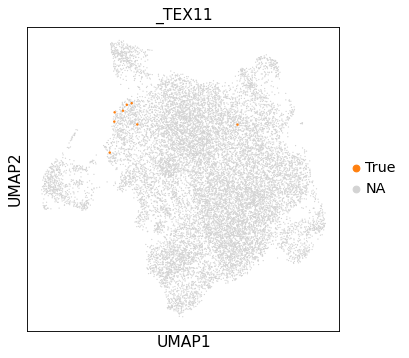

In [10]:
sc.pl.umap(
    adata,
    color="_TEX11",
    groups="True",
    size=[20 if x == "True" else 5 for x in adata.obs["_TEX11"]],
)

In [11]:
scvi_res

gene_symbol  proba_de  proba_not_de  bayes_factor    scale1  \
0             S100B  0.988911      0.011089      4.490676  0.003340   
1             TEX11  0.988105      0.011895      4.419656  0.000008   
2       CACNA1G-AS1  0.986492      0.013508      4.290868  0.000002   
3              CD1A  0.985282      0.014718      4.203874  0.000806   
4               LTB  0.985282      0.014718      4.203874  0.003367   
...             ...       ...           ...           ...       ...   
193232         ST13  0.493750      0.506250     -0.025001  0.000189   
193233         OAZ1  0.492944      0.507056     -0.028228  0.001902   
193234        CDC42  0.479435      0.520565     -0.082304  0.000417   
193235         EDF1  0.464919      0.535081     -0.140554  0.000355   
193236       ERGIC3  0.446169      0.553831     -0.216160  0.000106   

              scale2  lfc_mean  lfc_median   lfc_std   lfc_min    lfc_max  \
0       2.282279e-04  4.393521    4.311810  2.316819 -4.965695  15.105190   
1       5.724059e-07  4.658651    4.419306  2.944300 -6.919409  28.838980   
2       1.260032e-07  4.294108    4.165443  2.584643 -5.035019  19.826138   
3       6.945911e-05  4.073912    3.971226  2.178432 -3.995603  15.659993   
4       1.634798e-04  4.343693    4.347876  2.261448 -2.376017  13.067993   
...              ...       ...         ...       ...       ...        ...   
193232  1.783504e-04  0.097848    0.071920  0.420828 -1.565603   3.784390   
193233  1.762684e-03  0.131976    0.112570  0.405791 -1.553630   2.950152   
193234  4.106994e-04  0.045006    0.040743  0.395459 -1.776651   3.129409   
193235  3.733420e-04 -0.061367   -0.069788  0.374877 -1.687408   1.817972   
193236  1.059648e-04  0.031982    0.007690  0.392458 -2.041201   3.491743   

         raw_mean1   raw_mean2  non_zeros_proportion1  non_zeros_proportion2  \
0       384.165064   15.642730               0.892628               0.211018   
1         0.011218    0.000197               0.009615               0.000132   
2         0.091346    0.003423               0.014423               0.000197   
3       159.200321    2.108142               0.596154               0.062595   
4       300.549679   12.958928               0.940705               0.246693   
...            ...         ...                    ...                    ...   
193232   30.137209   14.026841               0.795349               0.657243   
193233  771.234884  395.660948               0.988372               0.980763   
193234  108.669767   50.481055               0.918605               0.843114   
193235   97.825581   55.650484               0.939535               0.833691   
193236   30.960465   18.810619               0.690698               0.506012   

        raw_normalized_mean1  raw_normalized_mean2  is_de_fdr_0.05  \
0                  34.357274              1.753272            True   
1                   0.009212              0.001158            True   
2                   0.012735              0.000038            True   
3                   6.764472              0.208127            True   
4                  25.005434              1.306680            True   
...                      ...                   ...             ...   
193232              1.790160              1.840915           False   
193233             19.984114             18.899690           False   
193234              3.876184              4.205143           False   
193235              3.995501              3.870598           False   
193236              1.214266              1.049326           False   

                      comparison  
0           DC_Lagerhans vs Rest  
1           DC_Lagerhans vs Rest  
2           DC_Lagerhans vs Rest  
3           DC_Lagerhans vs Rest  
4           DC_Lagerhans vs Rest  
...                          ...  
193232  myeloid_dividing vs Rest  
193233  myeloid_dividing vs Rest  
193234  myeloid_dividing vs Rest  
193235  myeloid_dividing vs Rest  
193236  myeloid_dividing vs Rest  

[193237

#### Results based on alternative scoring strategy
 * rank by log-fold change, require minimal expression level

In [12]:
scvi_res["score"] = scvi_res["lfc_mean"] * (scvi_res["raw_normalized_mean1"] > 0.5)
# de_res["score"] = de_res["bayes_factor"] * (de_res["raw_normalized_mean2"] - de_res["raw_normalized_mean1"]) * -1

In [13]:
scvi_res["cell_type"] = [x.split("vs")[0].strip() for x in scvi_res["comparison"]]

In [14]:
de.de_res_to_anndata(
    adata,
    scvi_res,
    groupby="cell_type",
    gene_id_col="gene_symbol",
    pval_col="proba_not_de",
    pval_adj_col="proba_not_de",
    lfc_col="lfc_mean",
)

#### Top genes for each group
score = log fold change

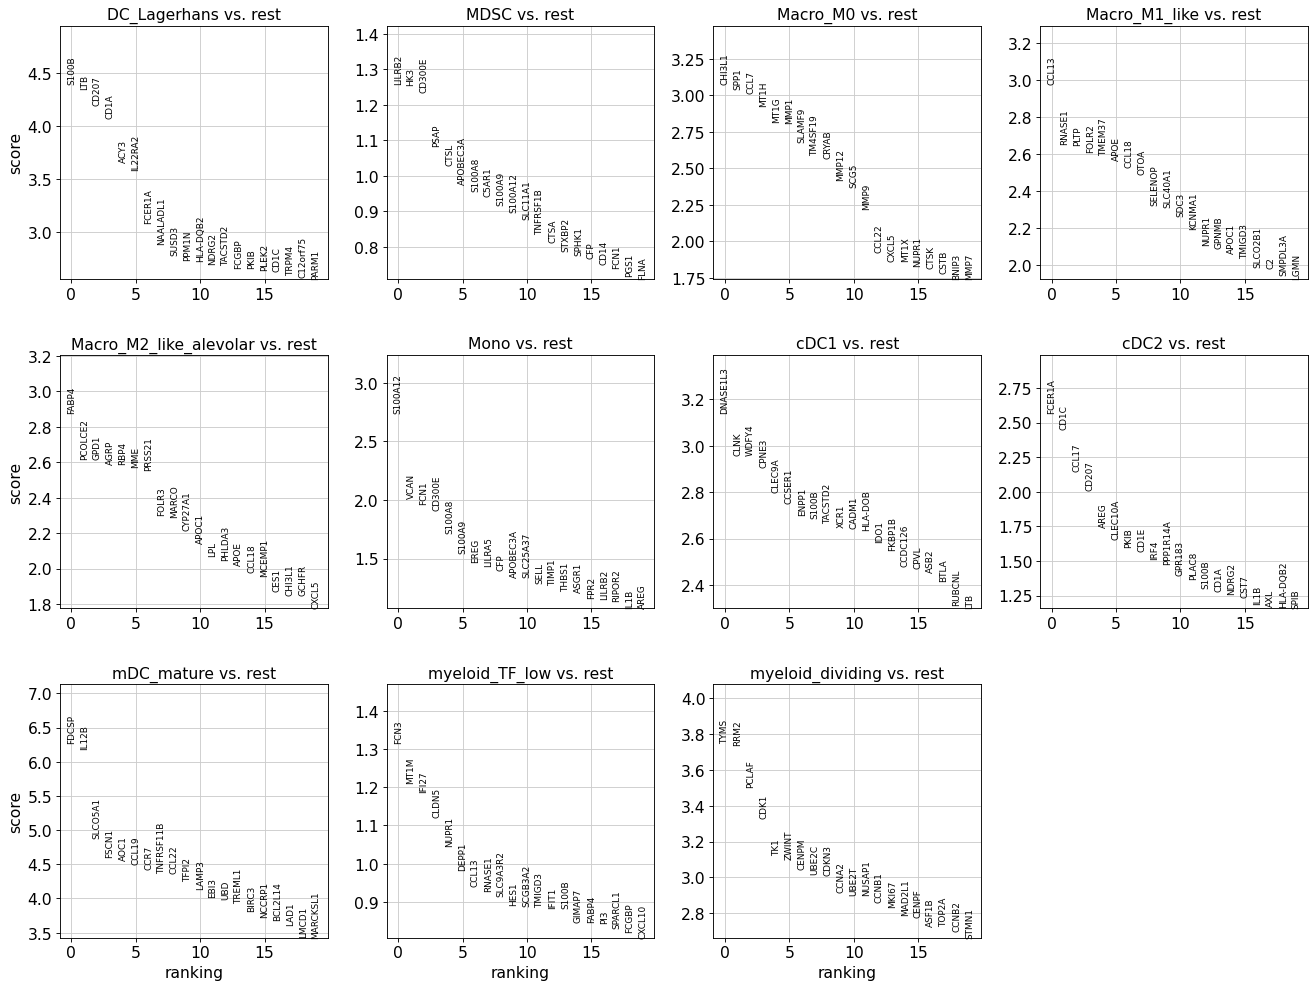

In [15]:
sc.pl.rank_genes_groups(adata, sharey=False)

         Falling back to preprocessing with `sc.pp.pca` and default params.
computing PCA
    with n_comps=50
    finished (0:00:46)
Storing dendrogram info using `.uns['dendrogram_cell_type']`


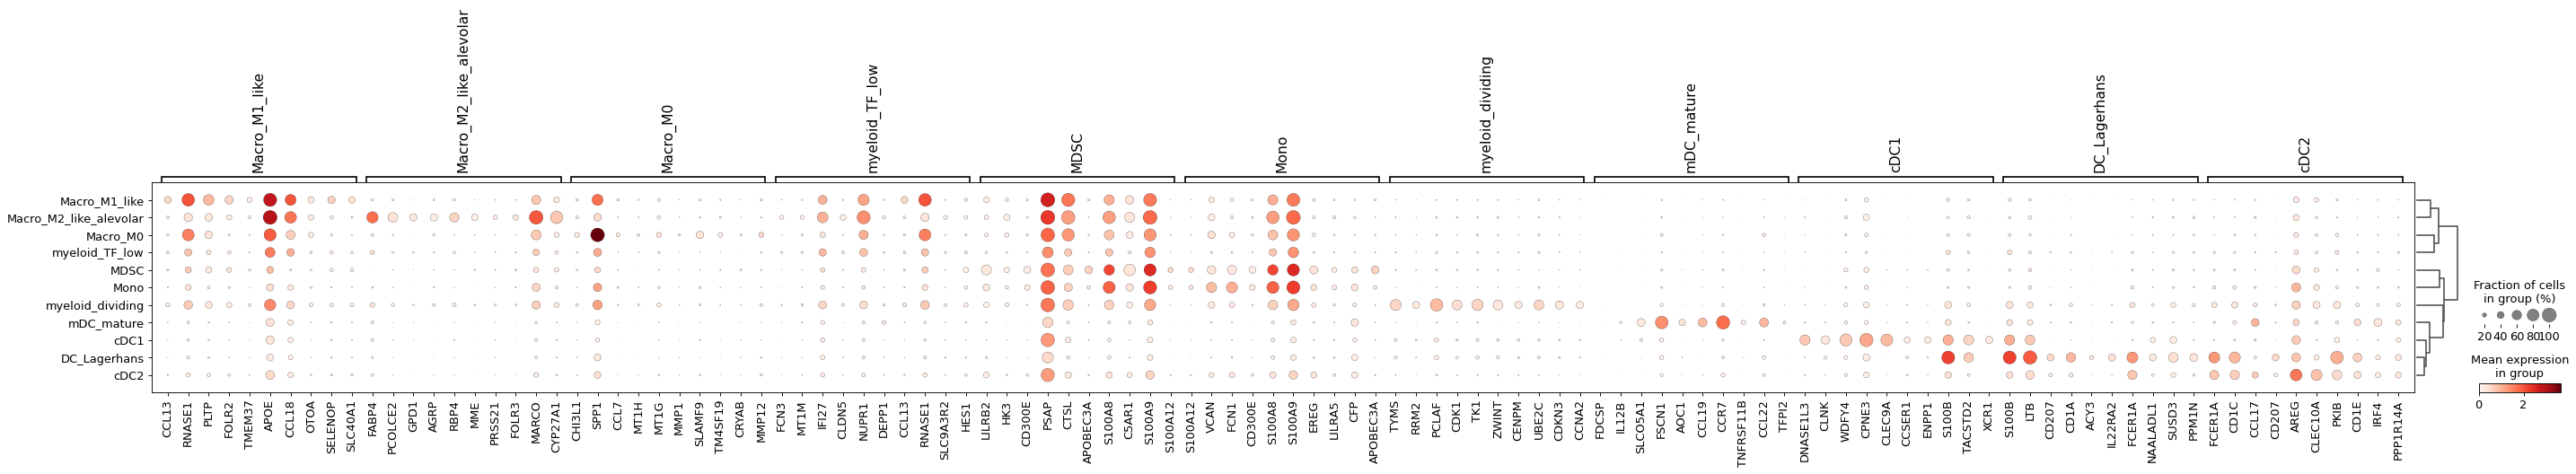

In [16]:
sc.pl.rank_genes_groups_dotplot(adata)

On first glance, the markers make sense: 

* CCR7 is the marker that was used for classifying mDC mature in the first place
* CDK1 is a marker for dividing cells
* Visual inspection of the top hits on UMAP are clearly restricted to a subset of cells (see "Plots" section at the end of the notebook) 

### MAST

 * Due to the immense statistical power arising from 15k cells, almost all differences between cells become statistically significant. In fact many comparisons hava a p-value of 0. 
 * Ranking by p-value (only) is therefore not viable to find marker genes. Ranking by log-fold change instead
 * Top MAST hits appear to be specific for several clusters, not a single one. 


#### APOE is a top hit for Macrophage M0, but also M1 and M2

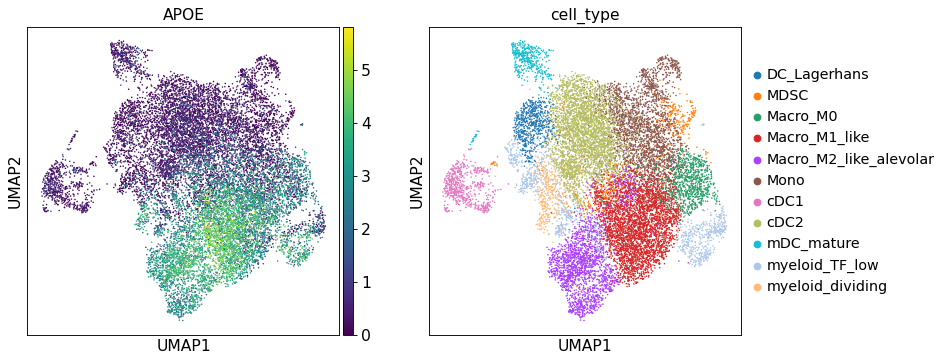

In [17]:
sc.pl.umap(adata, color=["APOE", "cell_type"])

In [18]:
# replace 0-pvalues with minimum nonzero pvalue.
mast_res["cell_type"] = mast_res["comparison"]
mast_res.loc[mast_res["coef"].isnull(), "coef"] = 0
mast_res.loc[mast_res["Pr(>Chisq)"] == 0, "Pr(>Chisq)"] = np.min(
    mast_res["Pr(>Chisq)"][mast_res["Pr(>Chisq)"] != 0]
)
mast_res["score"] = mast_res["coef"]

In [19]:
mast_res.sort_values("score")

primerid     Pr(>Chisq)      coef              comparison  \
51236     TYROBP  1.002953e-321 -2.464660                    cDC1   
149928  MTCO1P21  3.215264e-116 -2.121543          myeloid_TF_low   
163639       FTL  5.568892e-126 -1.922741              mDC_mature   
113948       LYZ  1.002953e-321 -1.921086            DC_Lagerhans   
106357     APOC1  1.071573e-124 -1.907300            DC_Lagerhans   
...          ...            ...       ...                     ...   
127899     FABP4  1.002953e-321  1.929553  Macro_M2_like_alevolar   
174184       TXN  1.002953e-321  2.135050              mDC_mature   
62093   MTCO1P21   1.327029e-80  2.193949           Macro_M1_like   
38649       CST3  1.002953e-321  2.403654                    cDC1   
132362  MTCO2P31   1.342403e-52  2.445671  Macro_M2_like_alevolar   

                     cell_type     score  
51236                     cDC1 -2.464660  
149928          myeloid_TF_low -2.121543  
163639              mDC_mature -1.922741  
113948            DC_Lagerhans -1.921086  
106357            DC_Lagerhans -1.907300  
...                        ...       ...  
127899  Macro_M2_like_alevolar  1.929553  
174184              mDC_mature  2.135050  
62093            Macro_M1_like  2.193949  
38649                     cDC1  2.403654  
132362  Macro_M2_like_alevolar  2.445671  

[193237 rows x 6 columns]

In [20]:
de.de_res_to_anndata(
    adata,
    mast_res,
    groupby="cell_type",
    gene_id_col="primerid",
    pval_col="Pr(>Chisq)",
    lfc_col="coef",
    score_col="coef",
)

#### Top genes for each group
score = log fold change

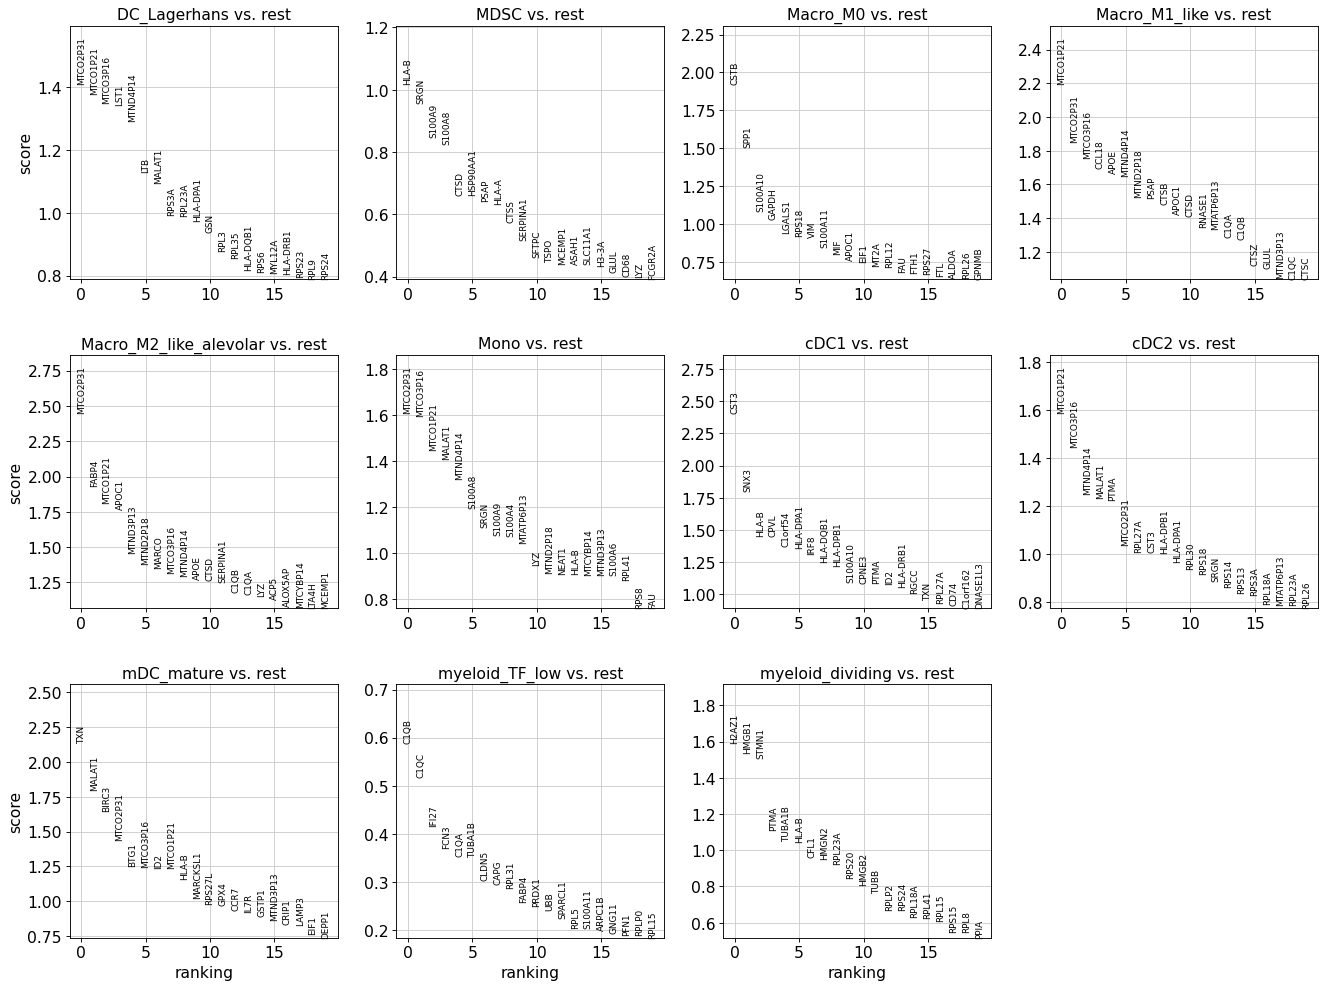

In [21]:
sc.pl.rank_genes_groups(adata, sharey=False)

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_cell_type']`


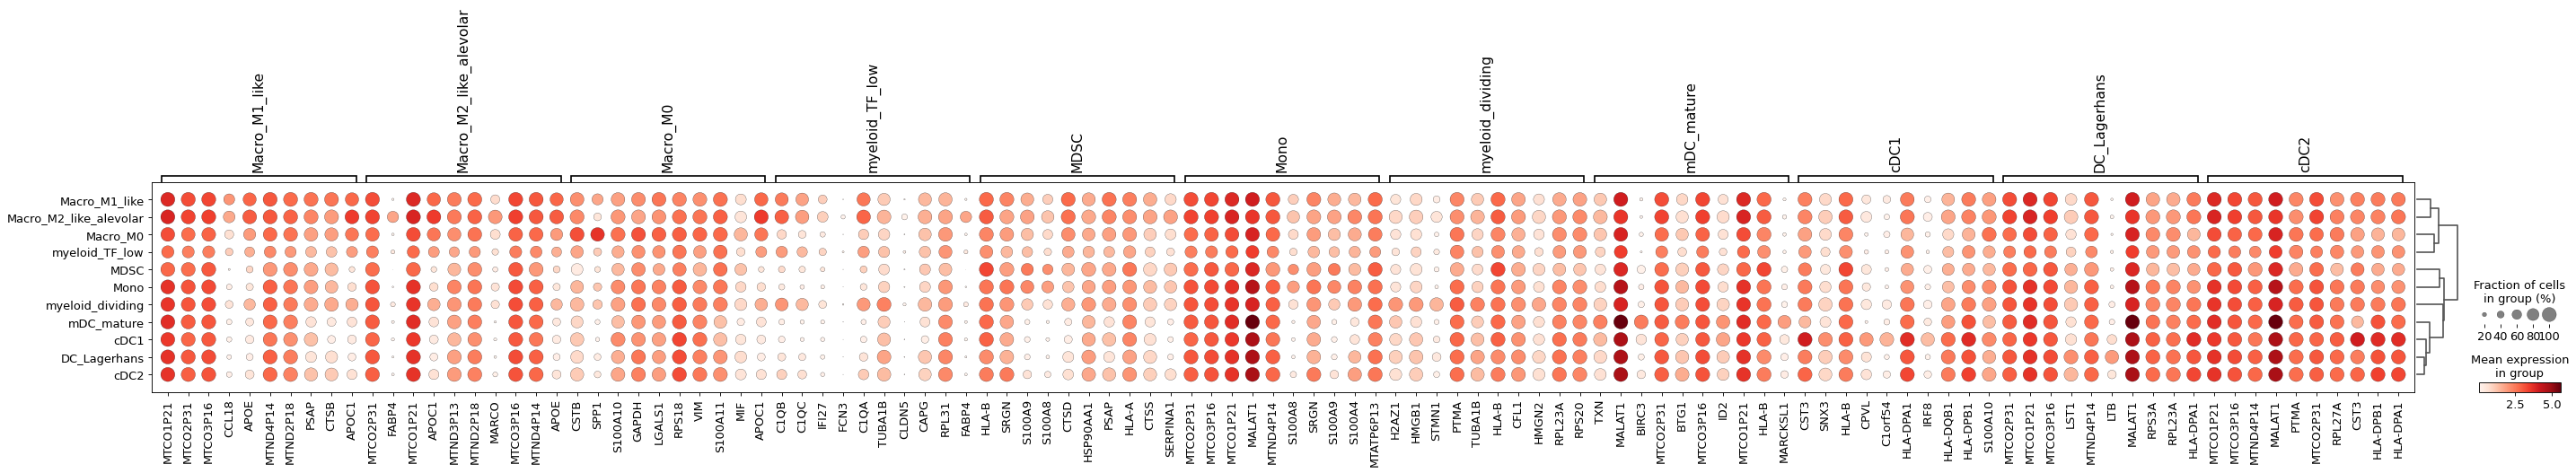

In [22]:
sc.tl.dendrogram(adata, groupby="cell_type")
sc.pl.rank_genes_groups_dotplot(adata)

### Gini-Index

In [23]:
gini_res = gini_res.sort_values(["CATEGORY", "GINI_IDX"], ascending=[True, False])

In [24]:
gini_res["GENE_SYMBOL"] = [adata.var_names[i] for i in gini_res["GENEID"]]

In [25]:
# merge MAST and gini results
gini_mast_df = gini_res.merge(
    mast_res,
    how="inner",
    left_on=["GENE_SYMBOL", "CATEGORY"],
    right_on=["primerid", "cell_type"],
)

 * VALUE = average gene expression in CATEGORY
 * Pr(>Chisq) = p-value for that gene from the MAST analysis (CATEGORY vs rest) 
 * coef = MAST log fold change

In [26]:
gini_mast_df

GENEID          CATEGORY     VALUE  RANKING  GINI_IDX GENE_SYMBOL  \
0         245      DC_Lagerhans  0.000595      1.0  0.909091  AC140912.1   
1        9529      DC_Lagerhans  0.000341      1.0  0.909091        MYL2   
2        5471      DC_Lagerhans  0.000084      1.0  0.909091       FOXN1   
3         486      DC_Lagerhans  0.000061      1.0  0.909091      ADRA2C   
4       11356      DC_Lagerhans  0.000006      1.0  0.909089        PON1   
...       ...               ...       ...      ...       ...         ...   
17553    5926  myeloid_dividing  0.992094      1.0  0.050836        GNG5   
17554    3337  myeloid_dividing  1.516128      1.0  0.049109      COX4I1   
17555    6714  myeloid_dividing  2.026746      1.0  0.046921    HSP90AA1   
17556    8757  myeloid_dividing  0.038968      1.0  0.045270        MBD1   
17557    9603  myeloid_dividing  0.063631      1.0  0.040400       NAA60   

         primerid    Pr(>Chisq)      coef        comparison         cell_type  \
0      AC140912.1  2.829827e-02  0.000000      DC_Lagerhans      DC_Lagerhans   
1            MYL2  4.523241e-02  0.000000      DC_Lagerhans      DC_Lagerhans   
2           FOXN1  1.784169e-03  0.000000      DC_Lagerhans      DC_Lagerhans   
3          ADRA2C  1.041763e-01  0.000000      DC_Lagerhans      DC_Lagerhans   
4            PON1  3.889492e-02  0.000000      DC_Lagerhans      DC_Lagerhans   
...           ...           ...       ...               ...               ...   
17553        GNG5  2.651288e-16  0.034412  myeloid_dividing  myeloid_dividing   
17554      COX4I1  5.421504e-07 -0.097320  myeloid_dividing  myeloid_dividing   
17555    HSP90AA1  8.520794e-07  0.129546  myeloid_dividing  myeloid_dividing   
17556        MBD1  9.696076e-06  0.001096  myeloid_dividing  myeloid_dividing   
17557       NAA60  7.622241e-10 -0.002564  myeloid_dividing  myeloid_dividing   

          score  
0      0.000000  
1      0.000000  
2      0.000000  
3      0.000000  
4      0.000000  
...         ...  
17553  0.034412  
17554 -0.097320  
17555  0.129546  
17556  0.001096  
17557 -0.002564  

[17558 rows x 12 columns]

In [27]:
gini_res

GENEID          CATEGORY     VALUE  RANKING  GINI_IDX GENE_SYMBOL
245       245      DC_Lagerhans  0.000595      1.0  0.909091  AC140912.1
9523     9529      DC_Lagerhans  0.000341      1.0  0.909091        MYL2
5470     5471      DC_Lagerhans  0.000084      1.0  0.909091       FOXN1
486       486      DC_Lagerhans  0.000061      1.0  0.909091      ADRA2C
11350   11356      DC_Lagerhans  0.000006      1.0  0.909089        PON1
...       ...               ...       ...      ...       ...         ...
5924     5926  myeloid_dividing  0.992094      1.0  0.050836        GNG5
3336     3337  myeloid_dividing  1.516128      1.0  0.049109      COX4I1
6712     6714  myeloid_dividing  2.026746      1.0  0.046921    HSP90AA1
8751     8757  myeloid_dividing  0.038968      1.0  0.045270        MBD1
9597     9603  myeloid_dividing  0.063631      1.0  0.040400       NAA60

[17558 rows x 6 columns]

In [28]:
gini_mast_df.to_csv(f"{output_dir}/gini_mast_res.csv")

In [29]:
gini_df_filtered = gini_mast_df.loc[
    (gini_mast_df["VALUE"] > 0.1)
    & (gini_mast_df["GINI_IDX"] > 0.6)
    & (gini_mast_df["Pr(>Chisq)"] < 0.01 / gini_mast_df.shape[0]),
    :,
]

In [30]:
gini_signatures = {
    cat: df.sort_values("VALUE", ascending=False)["GENE_SYMBOL"].values[:10]
    for cat, df in gini_df_filtered.groupby("CATEGORY")
}

In [31]:
var_group_labels = list(gini_signatures.keys())
c = -1
var_group_positions = [
    (c := c + 1, (c := c + len(group) - 1)) for group in gini_signatures.values()
]

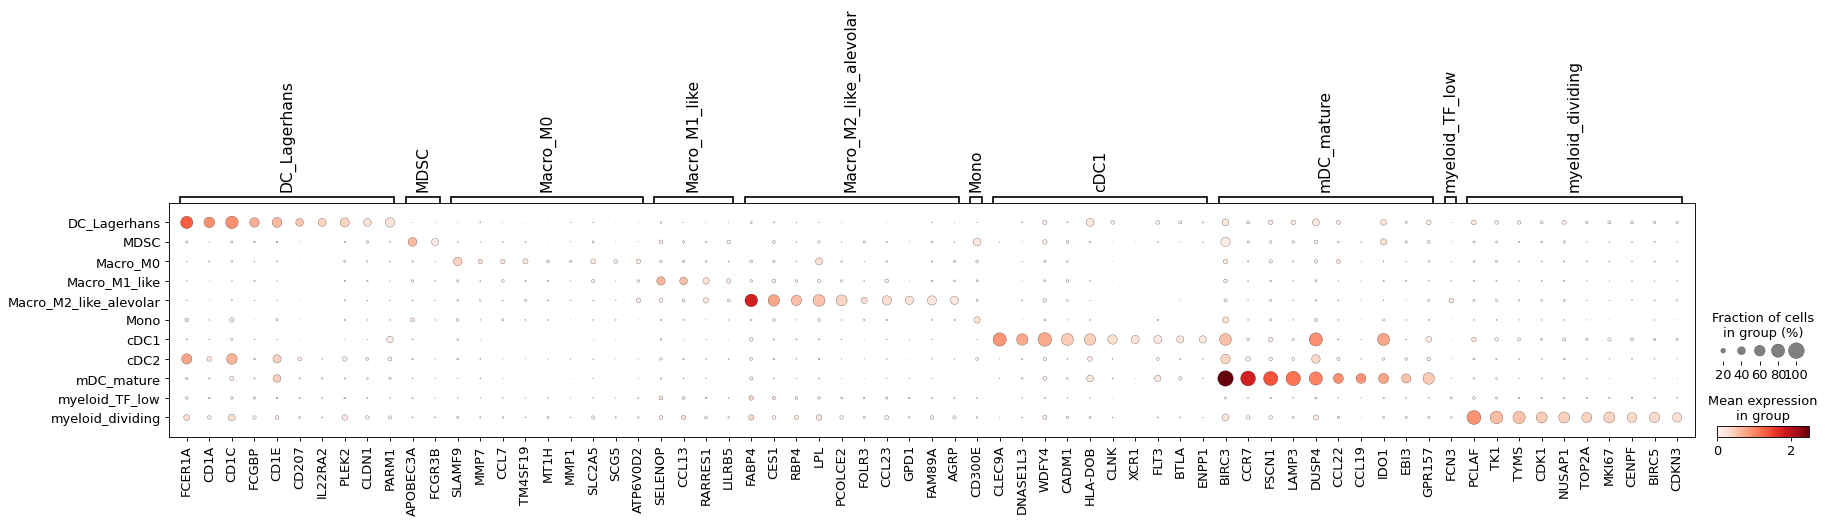

In [32]:
sc.pl.dotplot(
    adata,
    groupby="cell_type",
    var_names=list(itertools.chain.from_iterable(gini_signatures.values())),
    var_group_labels=var_group_labels,
    var_group_positions=var_group_positions,
)

### Compare gini against scVI

In [33]:
gini_scvi = gini_mast_df.merge(
    scvi_res,
    left_on=["GENE_SYMBOL", "cell_type"],
    right_on=["gene_symbol", "cell_type"],
)

In [34]:
top10_scvi = set(list(
    scvi_res.sort_values("score", ascending=False)
    .groupby("cell_type")
    .apply(lambda x: x["gene_symbol"][:10])
    .reset_index()["gene_symbol"]
    .values
))
top_gini = set(list(itertools.chain.from_iterable(gini_signatures.values())))
top_both = top10_scvi & top_gini
rest = set(gini_scvi["gene_symbol"]) - top10_scvi- top_gini

Scatterplot of gini index against scVI Bayes Factor. Genes with a high gini index also have a high bayes factor. 

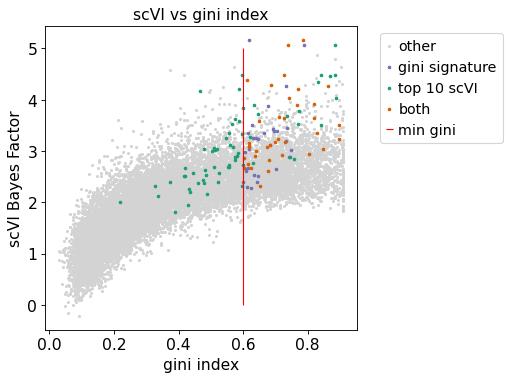

In [35]:
fig, ax = plt.subplots()
df_background = gini_scvi.loc[gini_scvi["gene_symbol"].isin(rest), :]
df_top10_scvi = gini_scvi.loc[gini_scvi["gene_symbol"].isin(top10_scvi - top_both), :]
df_top_gini = gini_scvi.loc[gini_scvi["gene_symbol"].isin(top_gini - top_both), :]
df_top_both = gini_scvi.loc[gini_scvi["gene_symbol"].isin(top_both), :]
background = ax.scatter(df_background["GINI_IDX"], df_background["bayes_factor"], c="lightgrey", s=3)
background.set_label("other")
tmp_sc = ax.scatter(df_top_gini["GINI_IDX"], df_top_gini["bayes_factor"], c="#7570b3", s=5)
tmp_sc.set_label("gini signature")
tmp_sc = ax.scatter(df_top10_scvi["GINI_IDX"], df_top10_scvi["bayes_factor"], c="#1b9e77", s=5)
tmp_sc.set_label("top 10 scVI")
tmp_sc = ax.scatter(df_top_both["GINI_IDX"], df_top_both["bayes_factor"], c="#d95f02", s=5)
tmp_sc.set_label("both")
red_line = ax.vlines(x=[0.6], ymin=0, ymax=5, color="red", lw=1)
red_line.set_label("min gini")
ax.legend(bbox_to_anchor=(1.05, 1))
ax.set_title("scVI vs gini index")
ax.set_xlabel("gini index")
ax.set_ylabel("scVI Bayes Factor")
ax.grid(False)

The same plot colored by the epression cutoff used for finding gini signature genes. 
Genes witha high gini index tend to be expressed at a lower level. 

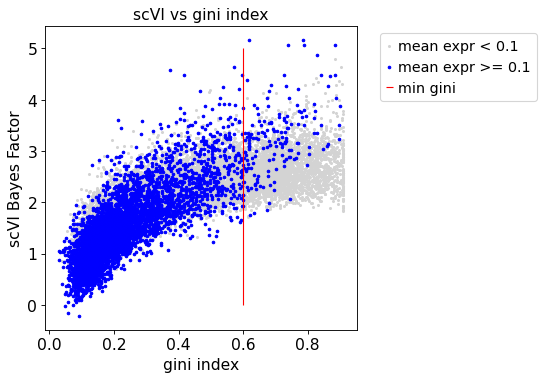

In [36]:
fig, ax = plt.subplots()
df_background = gini_scvi.loc[gini_scvi["VALUE"] < 0.1, :]
df_expr = gini_scvi.loc[gini_scvi["VALUE"] >= 0.1, :]
tmp_sc = ax.scatter(df_background["GINI_IDX"], df_background["bayes_factor"], c="lightgrey", s=3)
tmp_sc.set_label("mean expr < 0.1")
tmp_sc = ax.scatter(df_expr["GINI_IDX"], df_expr["bayes_factor"], c="blue", s=5)
tmp_sc.set_label("mean expr >= 0.1")
red_line = ax.vlines(x=[0.6], ymin=0, ymax=5, color="red", lw=1)
red_line.set_label("min gini")
ax.legend(bbox_to_anchor=(1.05, 1))
ax.set_title("scVI vs gini index")
ax.set_xlabel("gini index")
ax.set_ylabel("scVI Bayes Factor")
ax.grid(False)

## Plot marker genes


### Cell-type markers
Top markers tend to be in the top hits of both gini and scVI

DC Lagerhans


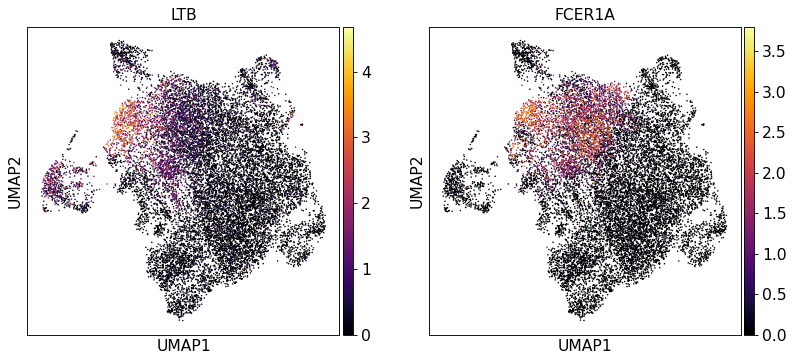

MDSC


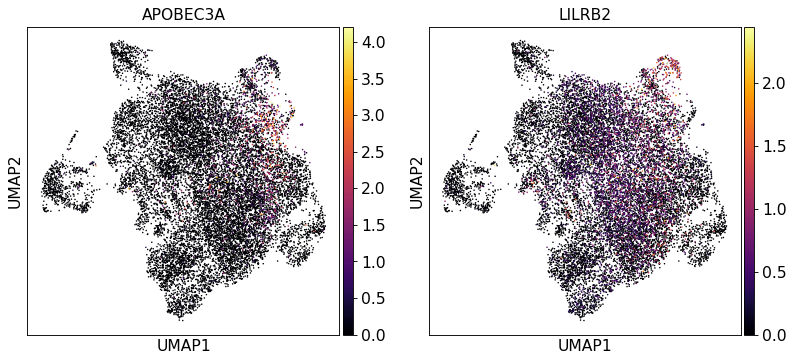

Macro M0


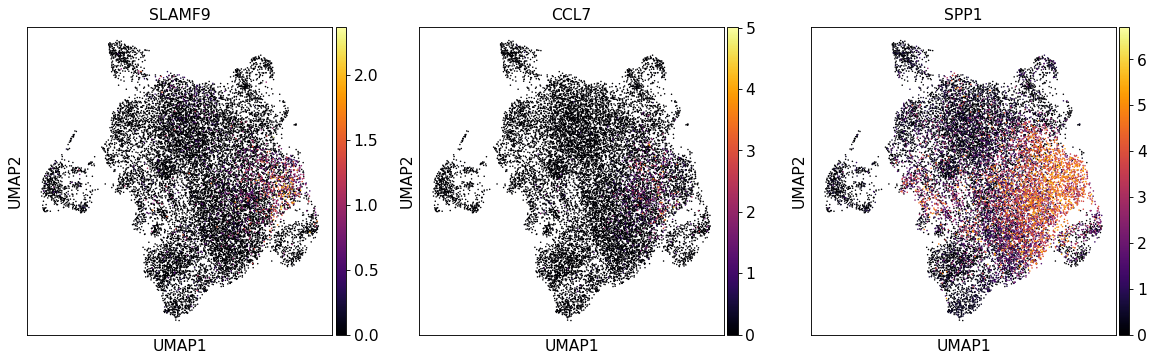

Macro M1


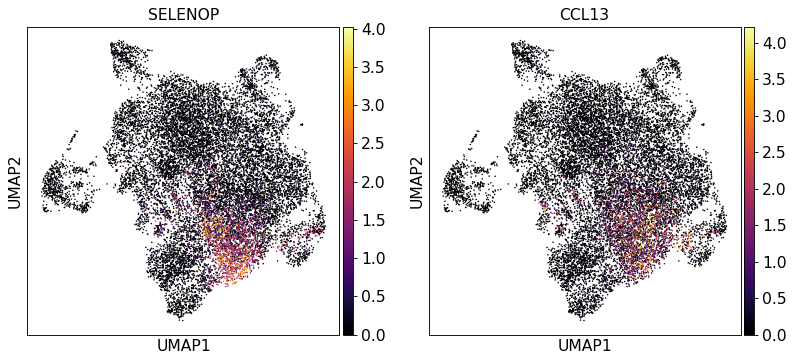

Macro M2 (alevolar)


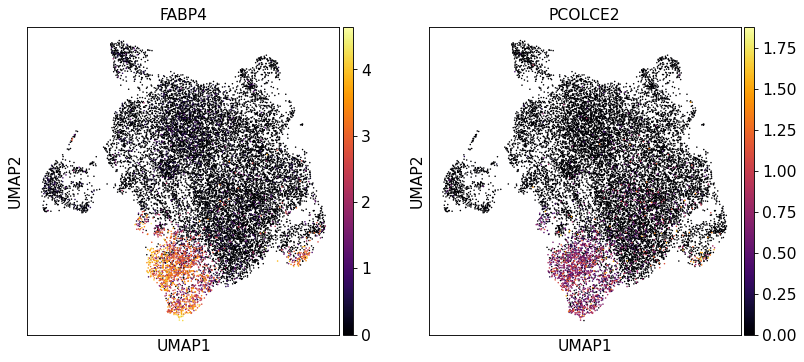

Mono


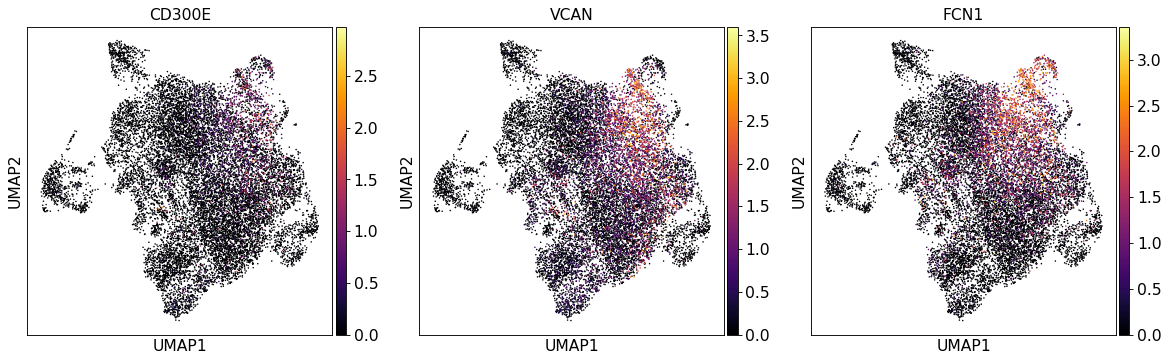

cDC1


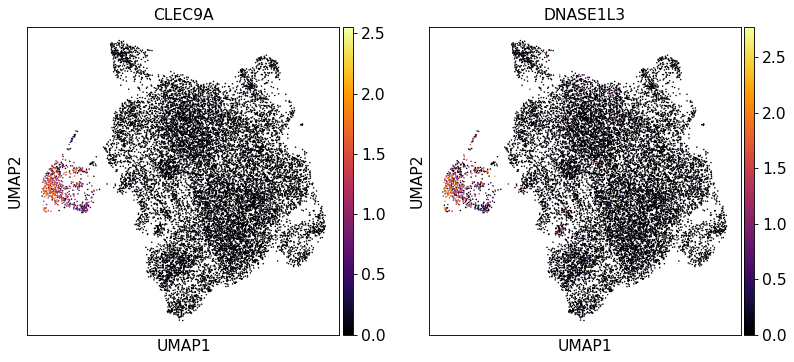

cDC2


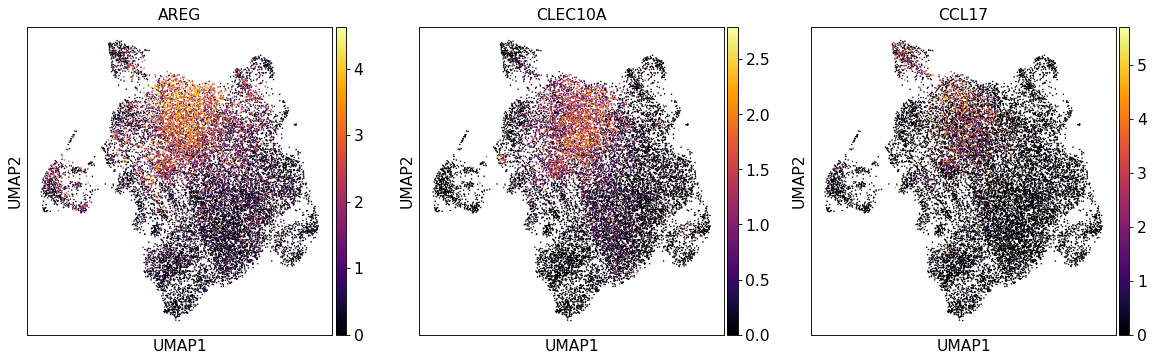

mDC_mature


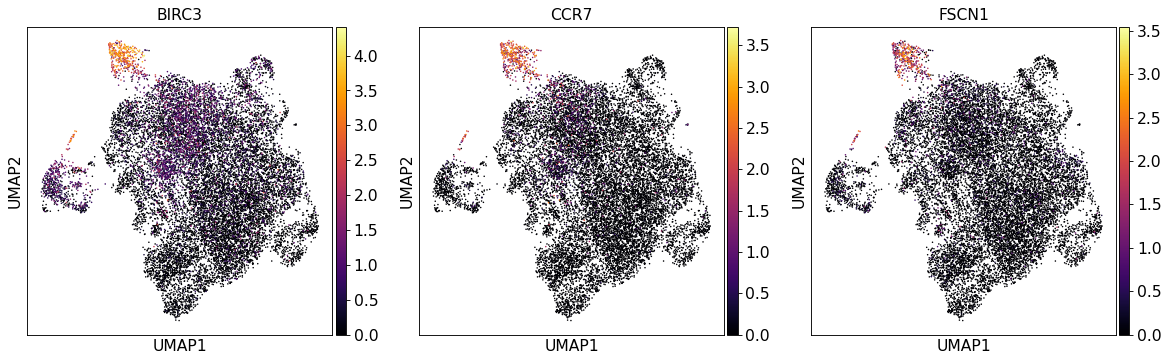

myeloid TF low


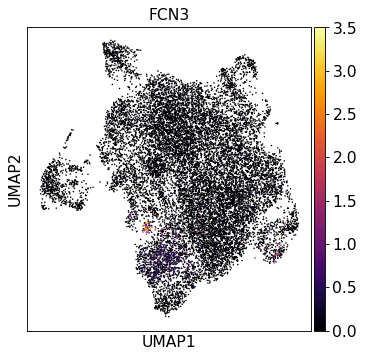

myeloid dividing


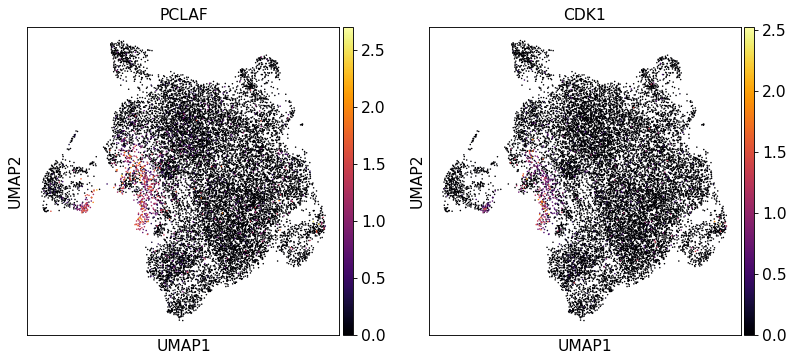

In [37]:
print("DC Lagerhans")
sc.pl.umap(adata, color=["LTB", "FCER1A"], cmap="inferno")

print("MDSC")
sc.pl.umap(adata, color=["APOBEC3A", "LILRB2"], cmap="inferno")

print("Macro M0")
sc.pl.umap(adata, color=["SLAMF9", "CCL7", "SPP1"], cmap="inferno")

print("Macro M1")
sc.pl.umap(adata, color=["SELENOP", "CCL13"], cmap="inferno")

print("Macro M2 (alevolar)")
sc.pl.umap(adata, color=["FABP4", "PCOLCE2"], cmap="inferno")

print("Mono")
sc.pl.umap(adata, color=["CD300E", "VCAN", "FCN1"], cmap="inferno")

print("cDC1")
sc.pl.umap(adata, color=["CLEC9A", "DNASE1L3"], cmap="inferno")

print("cDC2")
sc.pl.umap(adata, color=["AREG", "CLEC10A", "CCL17"], cmap="inferno")

print("mDC_mature")
sc.pl.umap(adata, color=["BIRC3", "CCR7", "FSCN1"], cmap="inferno")

print("myeloid TF low")
sc.pl.umap(adata, color=["FCN3"], cmap="inferno")

print("myeloid dividing")
sc.pl.umap(adata, color=["PCLAF", "CDK1"], cmap="inferno")

### Plot the cibersort/xCell scores by cell-type

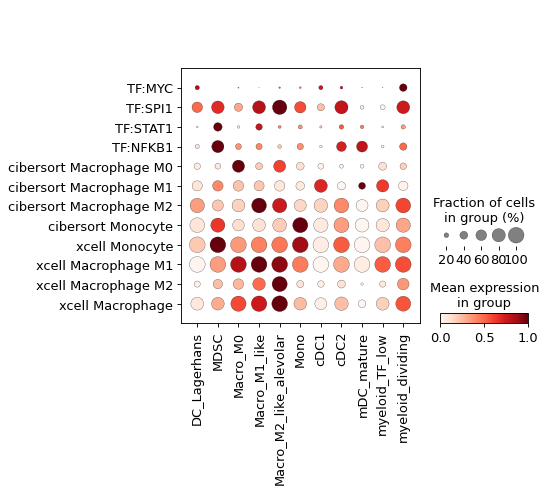

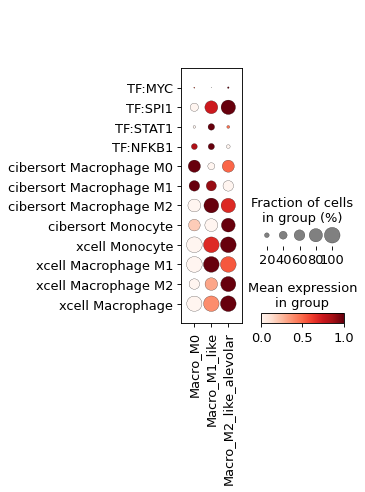

In [38]:
for tmp_adata in [
    adata,
    adata[
        adata.obs["cell_type"].str.startswith("Macro"),
    ],
]:
    sc.pl.dotplot(
        tmp_adata,
        var_names=[
            "TF:MYC",
            "TF:SPI1",
            "TF:STAT1",
            "TF:NFKB1",
            "cibersort Macrophage M0",
            "cibersort Macrophage M1",
            "cibersort Macrophage M2",
            "cibersort Monocyte",
            "xcell Monocyte",
            "xcell Macrophage M1",
            "xcell Macrophage M2",
            "xcell Macrophage",
        ],
        groupby="cell_type",
        standard_scale="var",
        swap_axes=True,
    )